In [1]:
%reload_ext autoreload
%autoreload 2

import dec 
from result_saver import SaverProvider

provider = SaverProvider()

In [2]:
DEVICE = 'ibm_sherbrooke'
LOGICAL = '0'
XBASIS = True
ROUNDS = 50


md = dec.load_metadata(DEVICE, LOGICAL, XBASIS, ROUNDS)
jobs_dict = dec.organize_jobs_by_calibration_date(md)

shape md before: (1, 18)
State: X0 50
shape md: (1, 18)
Calibration dates: dict_keys([datetime.datetime(2024, 3, 23, 13, 12, 1, 375000, tzinfo=datetime.timezone.utc)])
Num of calibrations: 1
Num of jobs per calibration: [1]



In [3]:
# for calib_date in jobs_dict:

calib_date = list(jobs_dict.keys())[0]

kde_dict, kde_dict_PS, msmt_error_dict, noise_dict = dec.retrieve_calib_data(provider, DEVICE, calib_date)

10:43:43 Warning: Negative T2 error -0.08 % for qubit 38, setting to 0. T1: 6.421500990479847e-05, T2: 0.00015673252358240422. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Hardware/backend_noise.py, LINE: 54
10:43:43 Warning: Negative T2 error -0.01 % for qubit 39, setting to 0. T1: 0.00013169172467058469, T2: 0.00027539403593426396. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Hardware/backend_noise.py, LINE: 54
10:43:43 Warning: Negative T2 error -0.01 % for qubit 111, setting to 0. T1: 0.00016588647661947383, T2: 0.00034179903119965343. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Hardware/backend_noise.py, LINE: 54
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 13:11:56.380893+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 13:12:25.263713+00:00.

In [4]:
big_memory, d, T, link_qubits, code_qubits, shots_per_job = dec.retrieve_memories_and_job_info(provider, jobs_dict[calib_date], md)

In [5]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

layout = link_qubits + code_qubits
inv_q_mapping = inv_qubit_mapping(get_repcode_IQ_map(layout, T))


Starting to get pSoft at 2024-04-18 10:44:34.024592
Starting to get pSoft_PS at 2024-04-18 10:45:06.088675
Finished getting pSofts at 2024-04-18 10:45:26.578718

sum mask_1: 6340
sum maskPS_1: 6252
10:45:26 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 154


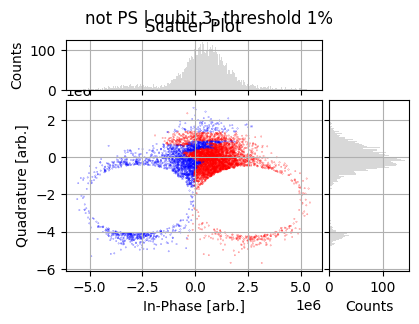

10:45:27 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 154


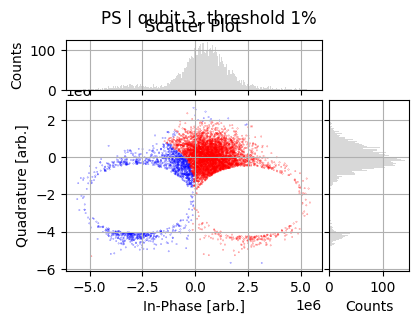

sum mask_1: 2062
sum maskPS_1: 2014
10:45:27 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 154


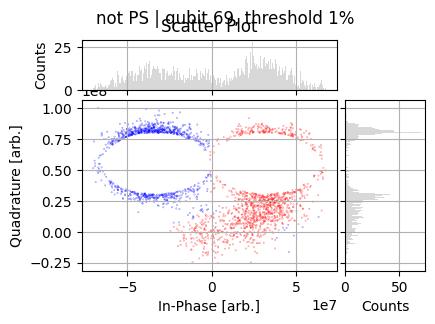

10:45:27 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 154


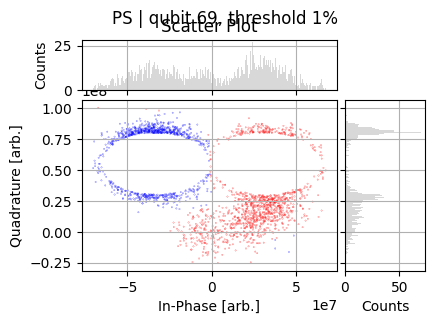

In [6]:
threshold = 0.01

pSoft, ratio, countMat, pSoft_PS, ratio_PS, countMat_PS = dec.get_pSoft_and_countMat(big_memory, kde_dict, kde_dict_PS, inv_q_mapping, threshold, plot = True)

In [16]:
# for d_small in: 
d_small = 15

pSoft_subset_big, countMat_subset_big, num_subsets, num_shots = dec.get_big_subset_mats(d_small, T, d, pSoft, countMat)
pSoft_subset_big_PS, countMat_subset_big_PS, num_subsets_PS, num_shots_PS = dec.get_big_subset_mats(d_small, T, d, pSoft_PS, countMat_PS)

In [17]:
import numpy as np
_RESETS = False

model_mean_for_soft, model_mean_for_hard, model_mean_mean_for_hard, model_mean_mean_for_hard_PS, noise_list = dec.get_stim_models(noise_dict, msmt_error_dict, np.mean(pSoft), np.mean(pSoft_PS), d_small,
                                                                                                                      d, T, LOGICAL, XBASIS, _RESETS, link_qubits, code_qubits)

print(noise_list)

[0.008774633384354788, 0.0003030722578189126, 0.0013368546211912028, 0.0037228032381900335, 0.023176929849005327, 0.01809322065246072, 0.005083709196544605]


In [23]:
from src import cpp_soft_info as csi

job_ids = jobs_dict[calib_date] 

nBits_res_dict = {}
for nBits in [3, 19]:
    pSoft_subset_big_quantized = csi.quantizeMatrixVectorized(pSoft_subset_big, nBits)
    pSoft_subset_big_PS_quantized = csi.quantizeMatrixVectorized(pSoft_subset_big_PS, nBits)

    res_s_K = csi.decodeConvertorAll(model_mean_for_soft, countMat_subset_big, pSoft_subset_big_quantized, T, 
                                                    int(LOGICAL), _RESETS, decode_hard=False)

    res_s_KPS = csi.decodeConvertorAll(model_mean_for_soft, countMat_subset_big_PS, pSoft_subset_big_PS_quantized, T,
                                                    int(LOGICAL), _RESETS, decode_hard=False)

    result_dict = {
        'dict_s_K': dec.res_to_job_subset_res(res_s_K, shots_per_job, num_subsets, job_ids),
        'dict_s_KPS': dec.res_to_job_subset_res(res_s_KPS, shots_per_job, num_subsets_PS, job_ids),
    }
    for method, job_ids_dict in result_dict.items():
        for job_id, err_per_subset_list in job_ids_dict.items():
            if method not in nBits_res_dict:
                nBits_res_dict[method] = {}
            if job_id not in nBits_res_dict[method]:
                nBits_res_dict[method][job_id] = []
            nBits_res_dict[method][job_id].append(sum(err_per_subset_list))

In [24]:
import os
import json
pSoft_mean = np.mean(pSoft) 
pSoft_PS_mean = np.mean(pSoft_PS)

file_name = 'testIP.json'


if not os.path.exists(file_name):
    data = {}
else:
    with open(file_name, "r") as f:
        data = json.load(f)

for job_id in job_ids:
    if job_id not in data:
        data[job_id] = {"additional_info": {
            'threshold': threshold,
            'ratio_leaked': ratio,
            'ratio_leaked_PS': ratio_PS,
            'pSoft_mean': pSoft_mean,
            'pSoft_PS_mean': pSoft_PS_mean,
            'noise_list': [float(noise) for noise in noise_list],
            'nBits_list': [1, 3, 19],
        }, "distances": {}}

    if str(d_small) not in data[job_id]['distances']:
        data[job_id]["distances"][str(d_small)] = {'tot_shots_with_all_subsets': float(num_shots/len(job_ids))}

    for method, res_dict in nBits_res_dict.items():
        data[job_id]['distances'][str(d_small)][method] = {
            'errs_per_bit': res_dict[job_id]
        }

with open(file_name, "w") as f:
    json.dump(data, f, indent=4)